### Problem Description:
As a media monitoring company, we try to make sense of the media that is created every day. One area in particular is written articles, where we want to automatically determine the type of the article. This knowledge helps us to filter articles and present to our customers only what they really care about.
You are given a corpus of text articles, included in this repo.

Your job is to create a service that **classifies** the *articles* into related groups by detecting patterns inside the dataset. When your service is given a new article, your model(s) should return the *type(s)* that this article belongs to.

### Plan of attack:
* Split the lines from text file to get articles and their labels
* Preprocess articles: remove stop words, punctuations, etc
* As it is mentioned in the problem description, associated article labels are not reliable, thus we need to use technique to define true article labels. For this challenge I use LDA since it is a well-known model for topic modeling. I have used LDA to cluster articles into topics based on their bag of words.
* Add true labels/topics to the dataset
* Build a classifier to detect patterns within articles. For this challenge, I decided to use CNN model as I have tried RNN models (both LSTM, bi-LSTM) and they did not perform well due to the length of articles. The CNN model I have created is inspired by [this](https://arxiv.org/pdf/1510.03820.pdf) article. To help the model not to start the training from scratch, I have used word embeddings from Universal Sentence Encoder (USE) model available [here](https://github.com/amansrivastava17/embedding-as-service). You can download the pretrained model from [here](https://www.dropbox.com/s/xy64gqdl32g8n01/isentia_article_classifier_cnn_model.h5?dl=1).
* You can also try the model as a service in [here](http://drstrange.cse.unsw.edu.au:5002).

* Results and observations
  * The CNN model achieved ~81% accuracy in classifying articles. However, it is clear that the model requires more tuning to reach to an acceptable level of performance. One approach to improve its performance is to train it with more diverse training data which is generated by text augmentation techniques (e.g. pivot language paraphrasing, synonym replacement).

### Install packages

In [ ]:
!pip install gensim
!pip install embedding_as_service
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install wordcloud

### Import libraries

In [6]:
import os
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.test.utils import datapath
import matplotlib.pyplot as plt
# import nltk
# from nltk.stem import WordNetLemmatizer, SnowballStemmer
# nltk.download('wordnet')
from wordcloud import WordCloud
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import re
import time
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, Conv1D, MaxPool1D, GlobalMaxPool1D
from embedding_as_service.text.encode import Encoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from embedding_as_service.text.encode import Encoder

PATH = "."
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

### Prepare articles to train our CNN model

We have the option: 


1.   Preprocess raw articles and assign appropriate topic labels to each
2.   Download *ready-to-use* articles from [here](https://www.dropbox.com/s/qbkm39innbud1c4/articles.csv?dl=1)

#### 1. Preprocess raw articles

Read [text file](https://bitbucket.org/isentia/coding-challenge-ml/src/master/) contains articles and their labels. We only use train.txt file for now.

In [2]:
filename = "train.txt"
lines = []
with open(os.path.join(PATH, filename), "r") as file:
  for line in file.readlines():
    lines.append(line)

Extract article texts and corresponding labels

In [4]:
articles = []
labels = []
num_topics = 0 # number of unique labels assigned to articles (can be found in the text file)
for line in lines:
  articles.append(line.split("__label__")[0])
  labels.append(line.split("__label__")[1].replace("\n", ""))
num_topics = len(set(labels))

Preprocess articles: 
*   remove stop words
*   filter out words with less than 3 characters

In [7]:
# we skip the stemming step for now
# stemmer = SnowballStemmer("english")
# def lemmatize_stemming(article):
#     return stemmer.stem(WordNetLemmatizer().lemmatize(article, pos='v'))

def preprocess(article):
    result = []
    article = re.sub('[,\.!?]', '', article)
    for word in gensim.utils.simple_preprocess(article):
        if word not in gensim.parsing.preprocessing.STOPWORDS and len(word) > 3: # remove stop words and words with less than 3 characters
            result.append(word)
    return result

# preprocess articles
processed_articles = []
for article in articles:
  processed_articles.append(preprocess(article))

Create a dictionary of most frequent words, we will use it later when categorise articles into topics (topic modelling). Inspired by [this](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24), we filter out words that appear in:
* less than 15 articles (absolute number) or
* more than 0.5 articles (fraction of total corpus size, not absolute number).
* after the above two steps, keep only the first 100k most frequent words.

In [8]:
dictionary = gensim.corpora.Dictionary(processed_articles)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

Create BoW to replace each word appears in an article with its index from the dictionary (convert corpus to BoW format).

In [9]:
bow_articles = [dictionary.doc2bow(bow_article) for bow_article in processed_articles]

Compute TF-IDF for each BoW formatted article.

In [10]:
tfidf_model = models.TfidfModel(bow_articles)
tfidf_converted_articles = tfidf_model[bow_articles]

##### Use LDA to form topics and categorise articles based on their bag-of-words. As it is mentioned in the problem description, initial labels assigned to articles are not reliable, thus, we use LDA model to classify each article into an appropriate topic and consider that topic as its true label.

We have two options: 
-   Create LDA model
-   Download *ready-to-use* model from [here](https://www.dropbox.com/s/t3td12qefngddo0/isentia-lda-model.zip?dl=1)

###### Create an LDA model using pre-processed articles. 

Using formatted articles, we create an LDA model to form topics each is represented by set of words.

In [11]:
lda_model_tfidf = gensim.models.LdaMulticore(tfidf_converted_articles, num_topics=num_topics, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.007*"dreamworld" + 0.007*"mareeba" + 0.007*"lambs" + 0.006*"cane" + 0.006*"solar" + 0.006*"fitbit" + 0.005*"sugar" + 0.005*"ergon" + 0.004*"timor" + 0.004*"agquip"
Topic: 1 Word: 0.002*"like" + 0.002*"life" + 0.002*"says" + 0.002*"film" + 0.002*"love" + 0.002*"people" + 0.001*"know" + 0.001*"family" + 0.001*"world" + 0.001*"think"
Topic: 2 Word: 0.013*"waste" + 0.010*"itunes" + 0.008*"crown" + 0.008*"recycling" + 0.007*"cladding" + 0.005*"madafferi" + 0.005*"landfill" + 0.005*"maryborough" + 0.004*"casino" + 0.004*"bins"
Topic: 3 Word: 0.007*"lotto" + 0.007*"lifeflight" + 0.005*"ticket" + 0.005*"prize" + 0.005*"division" + 0.005*"modal" + 0.004*"captions" + 0.004*"winning" + 0.004*"daffodil" + 0.004*"racq"
Topic: 4 Word: 0.006*"health" + 0.003*"students" + 0.003*"care" + 0.003*"cancer" + 0.003*"university" + 0.003*"patients" + 0.003*"research" + 0.003*"women" + 0.002*"people" + 0.002*"education"
Topic: 5 Word: 0.003*"city" + 0.003*"council" + 0.002*"community" + 0.002*

Save the LDA model and BoW dictionary

In [12]:
# save lda model
lda_model_tfidf.save(os.path.join(PATH, "lda-tfidf-model"))

# save bow dictionary
dictionary.save(os.path.join(PATH, "bow-dictionary"))

###### Download already created LDA model

In [ ]:
# load the pretrained lda model
!wget -O isentia_lda_model.zip -P PATH https://www.dropbox.com/s/t3td12qefngddo0/isentia-lda-model.zip?dl=1
!unzip isentia_lda_model.zip
fname = datapath(os.path.join(PATH, "lda-tfidf-model"))
lda_model_tfidf = models.LdaModel.load(fname, mmap='r')

# load bow dictionary
!wget -O bow-dictionary -P PATH https://www.dropbox.com/s/9a5t87a6mgw7zno/bow-dictionary?dl=1
fname = datapath(os.path.join(PATH, "bow-dictionary"))
dictionary = gensim.corpora.Dictionary.load(fname, mmap='r')

##### Assign topics to articles using LDA model

In [ ]:
article_lda_topics = []
for article in tfidf_converted_articles:
  topic_num, similarity_score = sorted(lda_model_tfidf[article], key=lambda item: item[1], reverse=True)[0]
  article_lda_topics.append(topic_num)

##### Create a dataframe contains pre-processed articles, their initial labels (not reliable) and lda clustered topics.

In [ ]:
# convert lists to dataframe
df = pd.DataFrame([" ".join(article) for article in processed_articles], columns=["article"])
df["initial_label"] = labels
df["lda_topic"] = article_lda_topics

# remove rows with missing article values (if any)
df.dropna(axis=0, inplace=True)

# drop very short articles with less than 50 words
short_articles = df.loc[df.article.str.split().str.len() < 50]
df.drop(short_articles.index, axis=0, inplace=True)

df.head()

#### 2. Download already pre-processed articles in CSV format

In [14]:
# download processed articles
!wget -O articles.csv -P PATH https://www.dropbox.com/s/qbkm39innbud1c4/articles.csv?dl=1

# load articles
df = pd.read_csv(os.path.join(PATH, "articles.csv"))

# remove rows with missing article values (if any)
df.dropna(axis=0, inplace=True)

# drop very short articles with less than 50 words
short_articles = df.loc[df.article.str.split().str.len() < 50]
df.drop(short_articles.index, axis=0, inplace=True)

df.head()

--2020-09-02 17:31:42--  https://www.dropbox.com/s/qbkm39innbud1c4/articles.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.83.1, 2620:100:6033:1::a27d:5301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.83.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qbkm39innbud1c4/articles.csv [following]
--2020-09-02 17:31:43--  https://www.dropbox.com/s/dl/qbkm39innbud1c4/articles.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf87ea47df1fbf394401fb06e6a.dl.dropboxusercontent.com/cd/0/get/A-kufzr8jv7OIDxRmbw-B7WtigsAxXSluAHqkVhuc7-FHa9-USJ5NQu_fXPDeFqjrtD-Jug403ZldMvUiuip9UWIXnjbkK8A5k25MlK-g5CMYK-sHTCRh4dF2r2bEx6ASJE/file?dl=1# [following]
--2020-09-02 17:31:43--  https://ucf87ea47df1fbf394401fb06e6a.dl.dropboxusercontent.com/cd/0/get/A-kufzr8jv7OIDxRmbw-B7WtigsAxXSluAHqkVhuc7-FHa9-USJ5NQu_fXPDeFqjrtD-Jug403ZldMvUiuip9UWIXnjbkK8A5k25MlK-g5CMY

,article,initial_label,lda_topic
0,investment accelerate divergent efforts global...,Energy&Resources&Utilities,7
1,interpol hunting fugitive queensland nickel di...,Legal&Defence,3
2,things victoria driving grunt work today host ...,Entertainment,9
3,thanks small mercies shorten believes economic...,Food&Beverage,2
4,heart australia future kids members guests iso...,"Information,Technology&Telecommunications",7


#### Prepare articles to train our model:


1. Tokenization
2. Padding
3. Split



In [15]:
articles = np.array(df.article.values)
article_labels = np.array(list(df.lda_topic.values))
num_labels = df.lda_topic.nunique()

Tokenize articles by considering 10k most frequent words

In [33]:
# tokenize articles and only consider top 10k most frequent words
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(articles)

# convert articles to sequences
article_sequences = tokenizer.texts_to_sequences(articles)

# save tokenizer for inference time
with open(os.path.join(PATH,'isentia_article_classifier_cnn_tokenizer'), 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file, protocol=pickle.HIGHEST_PROTOCOL)

Around *19k* articles have long texts (*more than 512 words*), at this stage we pad them all into first 512 words as the major number of articles have less than 512 words (*on average 277 words*).

However, proper treatment is that we split long texts into small chunks.

In [17]:
# set the maximum length for sequences
# mean_article_length = df.article.str.split().str.len().mean()
# long_articles = df.loc[df.article.str.split().str.len() > 512]

MAX_LEN = 512
padded_article_sequences = pad_sequences(article_sequences, maxlen=MAX_LEN, value=0, padding="post")

##### Split articles into train, validation and test

In [18]:
# split samples into train, validation, test
train_inputs, test_inputs, train_labels, test_labels = train_test_split(padded_article_sequences, article_labels, test_size=0.1, random_state=42, shuffle=True)
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels, test_size=0.1, random_state=42, shuffle=True)

##### Use embeddings from Universal Sentence Encoder [model](https://github.com/amansrivastava17/embedding-as-service) to create an embedding matrix, we will use this matrix as *already trained* weights for the first layer (embedding) in our CNN model.

In [19]:
# load the encoder model (Universal Sentence Encoder at the moment)
encoder = Encoder(embedding='use', model='use_dan')




Loading Model (this might take few minutes).....

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [20]:
# fill the embedding matrix as we will use it for Embedding layer in our model
# EMBEDDING_DIM = 768 # if we use bert base
EMBEDDING_DIM = 512
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
  embedding_vector = encoder.encode(texts=[word], pooling='reduce_mean')
  embedding_vector_flat = embedding_vector.flatten()
  if embedding_vector_flat is not None:
    embedding_matrix[i] = embedding_vector_flat

### Build or Download *Article Classifier* CNN model 

#### Build our Article Classifier CNN model

Inspired by the approach proposed in [here](https://arxiv.org/pdf/1510.03820.pdf), we could use kernel sizes 2, 3 and 4 in convolution layers. However, I have decided to choose a simpler architecture for now, which is faster in training.

In [25]:
input_sequence = Input(shape=(MAX_LEN,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False,
                            name="embeddings")
embedded_sequences = embedding_layer(input_sequence)
layers = Conv1D(filters=150, kernel_size=2, activation="relu")(embedded_sequences)
# layers = Conv1D(filters=32, kernel_size=3, activation="relu")(layers)
# layers = MaxPool1D()(layers)
# layers = Conv1D(filters=64, kernel_size=3, activation="relu")(layers)
# layers = Conv1D(filters=64, kernel_size=3, activation="relu")(layers)
# layers = MaxPool1D()(layers)
# layers = Conv1D(filters=128, kernel_size=4, activation="relu")(layers)
# layers = LSTM(64, return_sequences=True, name="lstm1_layer")(layers)
# layers = Bidirectional(LSTM(32, return_sequences=True, name="bilstm1_layer"))(layers)
# layers = Bidirectional(LSTM(32, name="bilstm2_layer"))(layers)
layers = GlobalMaxPool1D()(layers)
layers = Dropout(0.3)(layers)
preds = Dense(num_labels, activation="softmax")(layers)

model = Model(inputs=input_sequence, outputs=preds)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 512, 512)          224827392 
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 511, 150)          153750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 150)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                3473      
Total params: 224,984,615
Trainable params: 157,223
Non-trainable params: 224,827,392
_______________________________________

Set learning rate and early stopping schedulers to avoid overfitting.

In [23]:
def lr_scheduler(epoch):
  if epoch < 20:
    return 0.001
  else:
    return float(0.001 * np.exp(0.1 * (20 - epoch)))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
er_callback = tf.keras.callbacks.EarlyStopping(monitor="val_acc", 
                patience=5, 
                mode='max', 
                restore_best_weights=True)

Train our model

In [26]:
model.fit(train_inputs, 
          np.array(train_labels), 
          validation_data=(validation_inputs, np.array(validation_labels)),
          epochs=30,
          batch_size=16,
          callbacks=[lr_callback, er_callback])

Train on 177867 samples, validate on 19763 samples
Epoch 1/30
177867/177867 [==============================] - 286s 2ms/sample - loss: 1.0202 - acc: 0.6748 - val_loss: 0.7238 - val_acc: 0.7611
Epoch 2/30
177867/177867 [==============================] - 280s 2ms/sample - loss: 0.8033 - acc: 0.7342 - val_loss: 0.6706 - val_acc: 0.7765
Epoch 3/30
177867/177867 [==============================] - 284s 2ms/sample - loss: 0.7476 - acc: 0.7524 - val_loss: 0.6283 - val_acc: 0.7877
Epoch 4/30
177867/177867 [==============================] - 283s 2ms/sample - loss: 0.7169 - acc: 0.7617 - val_loss: 0.6260 - val_acc: 0.7879
Epoch 5/30
177867/177867 [==============================] - 283s 2ms/sample - loss: 0.6913 - acc: 0.7701 - val_loss: 0.6038 - val_acc: 0.7960
Epoch 6/30
177867/177867 [==============================] - 284s 2ms/sample - loss: 0.6747 - acc: 0.7753 - val_loss: 0.6009 - val_acc: 0.7969
Epoch 7/30
177867/177867 [==============================] - 283s 2ms/sample - loss: 0.6595 - acc:

Plot Training/Validation loss

<function matplotlib.pyplot.show(close=None, block=None)>

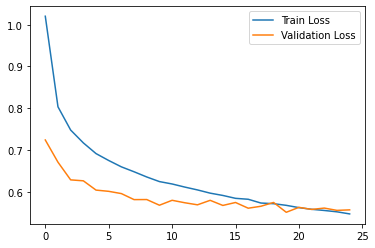

In [27]:
plt.plot(model.history.history["loss"],label="Train Loss")
plt.plot(model.history.history["val_loss"],label="Validation Loss")
plt.legend()
plt.show

Plot Training/Validation accuracy

<function matplotlib.pyplot.show(close=None, block=None)>

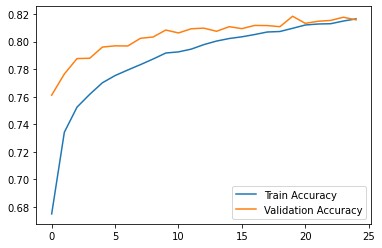

In [28]:
plt.plot(model.history.history["acc"],label="Train Accuracy")
plt.plot(model.history.history["val_acc"],label="Validation Accuracy")
plt.legend()
plt.show

Model's accuracy is not promising, **81%** for now, however, we can improve it more by using text augmentation (e.g. pivot language paraphrasing, replacing words with their synonyms) to generate more training data.

Now save the model.

In [29]:
model.save(os.path.join(PATH,'isentia_article_classifier_cnn_model.h5'))

#### Download/Load the pretrained Article Classifier model
Since I have already trained the model, you can skip the building/training section and load the pre-trained model available at [here](https://www.dropbox.com/s/xy64gqdl32g8n01/isentia_article_classifier_cnn_model.h5?dl=1).

In [ ]:
# load pretrained model
!wget -O isentia_article_classifier_cnn_model.h5 -P PATH https://www.dropbox.com/s/xy64gqdl32g8n01/isentia_article_classifier_cnn_model.h5?dl=1
model = load_model(os.path.join(PATH,'isentia_article_classifier_cnn_model.h5'))

### Try our model with new unseen articles (inference time): CNN vs LDA

In [58]:
# take unseen article from test.txt file
unseen_article = 'SEPHORA OPENS AT HIGHPOINT SHOPPING CENTRE ON 2 NOVEMBER Global beauty giant SEPHORA has today announced its next store location, continuing its extensive retail expansion in Australia, opening at Highpoint Shopping Centre on November 2nd 2017. This will be SEPHORA’s 13th Australian store and third in Victoria, (Melbourne Central and Chadstone). SEPHORA has been in high demand with Victorian beauty lovers since the opening of its first Victorian store, Melbourne Central in 2015. SEPHORA enthusiasts will be able to shop over 100 cosmetic brands in the new Highpoint store including exclusive lines from Marc Jacobs Beauty, Givenchy, Tarte, Anastasia Beverly Hills and the new Fenty Beauty by Rihanna As SEPHORA’s retail expansion continues, the product offering in-store and online continues to grow, with the recent launch of its new Wellness Category. Aimed to promote beauty from the inside out, the all-new Wellness Category features leading health and wellness brands including; KORA Organics, The Beauty Chef & WellCo, which will also play a part of the Highpoint store offering. SEPHORA Highpoint Shopping Centre, 120-200 Rosamund Road, Maribyrnong 3032'

Ask from LDA

In [59]:
# load the pretrained lda model
!wget -O isentia_lda_model.zip -P PATH https://www.dropbox.com/s/t3td12qefngddo0/isentia-lda-model.zip?dl=1
!unzip isentia_lda_model.zip
fname = datapath(os.path.join(PATH, "lda-tfidf-model"))
lda_model_tfidf = models.LdaModel.load(fname, mmap='r')

# load bow dictionary
!wget -O bow-dictionary -P PATH https://www.dropbox.com/s/9a5t87a6mgw7zno/bow-dictionary?dl=1
fname = datapath(os.path.join(PATH, "bow-dictionary"))
dictionary = gensim.corpora.Dictionary.load(fname, mmap='r')

def preprocess(article):
    result = []
    article = re.sub('[,\.!?]', '', article)
    for word in gensim.utils.simple_preprocess(article):
        if word not in gensim.parsing.preprocessing.STOPWORDS and len(word) > 3: # remove stop words and words with less than 3 characters
            result.append(word)
    return result

article_bow_vector = dictionary.doc2bow(preprocess(unseen_article))
for index, score in sorted(lda_model_tfidf[article_bow_vector], key=lambda item: item[1], reverse=True)[0:1]:
    print("LDA => Topic {}".format(index))

LDA => Topic 17


Ask from CNN

In [61]:
# download the tokenizer and load it, in case we skipped the "building cnn model" section
!wget -O isentia_article_classifier_cnn_tokenizer -P PATH https://www.dropbox.com/s/slrp5qfwzgc7qk6/isentia_article_classifier_cnn_tokenizer?dl=1

with open(os.path.join(PATH,'isentia_article_classifier_cnn_tokenizer'), 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

# convert articles to sequences
MAX_LEN = 512
article_sequence = tokenizer.texts_to_sequences([unseen_article])
padded_article_sequence = pad_sequences(article_sequence, maxlen=MAX_LEN, value=0, padding="post")

predictions = model.predict(padded_article_sequence)
print("CNN => Topic {}".format(np.argmax(predictions, axis=1)[0]))


CNN => Topic 17
